In [1]:

import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Classifiers 
import xgboost

# Analysis libs
from itertools import cycle
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X.shape

(58596, 50)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [7]:
xgb = xgboost.XGBClassifier(device="cuda")
clf = xgb.fit(X_train, y_train)

print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9237633176487797
Test accuracy: 0.8735422947835485


In [10]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"F-1 score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score: 0.8735422947835485
Precision score: 0.8732728575790144
Recall score: 0.8735422947835485
F-1 score: 0.8733341217095851


In [8]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8789,    0,    1,    0],
       [   0, 2101,  402,  434],
       [   0,  257, 2421,  328],
       [   0,  504,  297, 2045]])

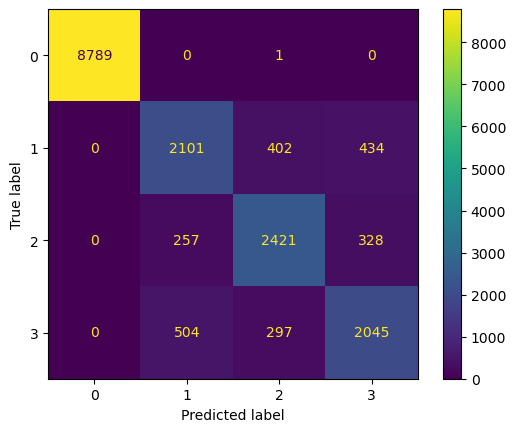

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       0.73      0.72      0.72      2937
           2       0.78      0.81      0.79      3006
           3       0.73      0.72      0.72      2846

    accuracy                           0.87     17579
   macro avg       0.81      0.81      0.81     17579
weighted avg       0.87      0.87      0.87     17579



In [11]:
scores = cross_val_score(clf, X, y, cv=10)

In [12]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.76399317 0.78805461 0.84556314 0.86604096 0.87440273 0.8725256
 0.85082779 0.86209251 0.79877112 0.80150196]
Mean of CV scores: 0.8323773582487665
Standard Deviation of CV scores: 0.03825192293912264


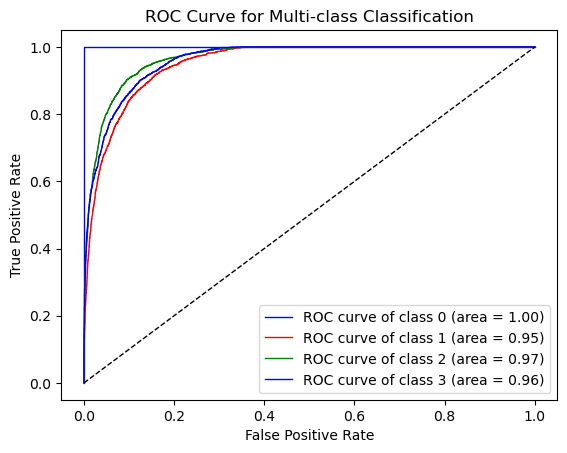

In [14]:
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

classifier = OneVsRestClassifier(xgboost.XGBClassifier(device="cuda"))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

## Report and results

In using XGboost, we can see that this model does not perform as well as the binary task. However, the model still had performed well in the multi-classification task as it is able to tell which sample was benign, but for maligment samples it had trouble defining which type of malware the sample was. When we train the model we can see that the model has great accuracy, but when tested the model falls quite short from 0.92 to 0.87. This, of course, indicates that the model is overfitting. There isn't much that we can do to mitigate this as we have tested this with the binary task and the model did exceptionally well, which means all the chosen features have a level of importance to help the model define binary task but not multiple classes. Therefore, this would be a more accurate depiction of performance as the train and test data only has numerical features as we removed the categorical and/or least significant features.   